# Customer segmentation
_Jayeeta Ghosh (Aug 2018)_

____
### Create Clustering Models to identify natural groups within customers based on promotion usage and buying pattern

Main goal is to create clusters with following attributes
1. Purchasing pattern
2. Promo/sales usage 
3. Demographics 


### Workflow: 
Define time window to capture transaction and customer information: <br />
2 months between '2017-01-29' and '2017-03-30 - plan is to go atleast one fiscal year

1. Check duplicates and remove if exists
2. Remove variables that are >90% null, and all constant variables
3. Run plain descriptive statistics
4. Make sure to check if the datatypes are correct, otherwise change into proper types including date, numerical and object type
5. Remove customers based on EDA before running clustering algorithm
6. Run experimentation on clustering

  -6a. Kmeans - numerical, assess cluster quality based on silhouette score
  
  -6b. Kmeans - numerical and binary categorical, assess cluster quality based on silhouette score
    
    TODO Try Hierarchical/ Minibatch Kmeans clustering algo to make sure categorical features are handled properly 


In [1]:
import sys, os, time
sys.path.append('/mnt/Opaisle/resources/python/')
sys.path.append('/home/ubuntu/.local/lib/python3.4/site-packages')
# sys.path.insert(0, '/home/ubuntu/.local/lib/python3.4/site-packages')
import helper_functions as gp
import pandas as pd

In [2]:
# set display right
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 200)

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

import datetime#, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
# from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
# import plotly.graph_objs as go
# from plotly.offline import init_notebook_mode,iplot
# init_notebook_mode(connected=True)
# warnings.filterwarnings("ignore")
# plt.rcParams["patch.force_edgecolor"] = True
# plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

%matplotlib inline

In [4]:
# Data directory
DataDir = "Input/"
OutDir = "Output/ModelFigures/"

In [5]:
query_list = [
    """
    SELECT  TOP 100000 *
    FROM
        dbo.cust_demo
        
    ORDER BY
        customer_key
    
    """
]

In [6]:
%%time
dforiginal = gp.dmno_execute(query_list, connection='azure')
# 100k data pull takes about 2 mins

COMPLETED! 128.09 seconds.
CPU times: user 2min 4s, sys: 8.32 s, total: 2min 13s
Wall time: 2min 9s


In [5]:
# Read local dataset for faster experiment
# df = pd.read_csv(DataDir +"ModelingData100K.csv")
# df = pd.read_csv(DataDir +"ModelingData1.1M.csv", dtype={'customer_key':object})

In [7]:
# Check duplicate rows if exists
print('Duplicates: {}'.format(dforiginal.duplicated().sum()))

Duplicates: 0


In [8]:
# Remove duplicate rows if exists
print('Dataframe dimensions before:', dforiginal.shape)
dforiginal.drop_duplicates(inplace = True)
print('Dataframe dimensions after:', dforiginal.shape)

Dataframe dimensions before: (100000, 54)
Dataframe dimensions after: (100000, 54)


In [9]:
# df.to_csv(DataDir + "ModelingData100K.csv")

In [10]:
# Percent discount
dforiginal['perc_discount'] = 100.0 * (-dforiginal['total_discount_amt'])/dforiginal['total_sales_amt']

In [11]:
# Keep customers who purchased and got discount within the time window
# and drop other customers who only returned within the time window
dforiginal = dforiginal[(dforiginal['total_discount_amt'] <= 0) & (dforiginal['total_sales_amt'] > 0)] 

In [12]:
# Change a few numerical columns to string
colsToString = ['customer_key']
dforiginal[colsToString] = dforiginal[colsToString].astype(str)

### Lets consider only transaction level features

In [34]:
# txnCols = ['avg_basket_size', 'avg_basket_price', 'count_num_txn', 'count_num_product', 'total_sales_amt', 'count_num_items', 
#            'min_sales_amt', 'total_cost_amt', 'total_diff_sale_cost', 'total_discount_amt', 'count_num_return', 
#            'count_online_ord', 'count_retail_ord', 'count_onsale_flag', 'count_promo_code', 'avg_daysinto_promo', 
#            'count_regular_priced', 'count_markdown_priced']

# txnColsToAdd = ['avg_basket_price', 'total_sales_amt', 'total_discount_amt', 'count_onsale_flag', 'count_promo_code', 
#                 'count_markdown_priced']

# demoCols = ['age', 'mega_age', 'mega_type_age', 'gender', 'nm1_gender', 'nm1_marital_status', 'mega_homeowner', 
#             'mega_type_homeowner', 'mega_education', 'mega_type_education', 'ethnic_code', 'group_ethnic_code', 
#             'mega_presence_of_children', 'mega_type_presence_of_children', 'mega_number_of_children', 'address_type', 
#             'mega_income', 'mega_type_income', 'adjusted_net_worth', 'home_value', 'credit_ranges', 'new_credit_range', 
#             'num_credit_lines', 'bank_card', 'social_iq_facebook', 'social_iq_twitter', 'mega_fitness_or_exercise', 
#             'mega_type_fitness_or_exercise', 'merkle_inf_cardholders_rank', 'merkle_marketing_index', 'merkle_marketing_rank', 
#             'merkle_responder_rating', 'spoken_language']

# demoColsToAdd = ['gender', 'nm1_marital_status', 'mega_education', 'mega_presence_of_children', 'adjusted_net_worth']


In [13]:
featureset1 = ['customer_key', 'avg_basket_price', 'total_sales_amt', 'perc_discount']
featureset2 = ['customer_key', 'avg_basket_price', 'total_sales_amt', 'perc_discount', 
               'count_onsale_flag']
featureset3 = ['customer_key', 'avg_basket_price', 'total_sales_amt', 'perc_discount', 
               'adjusted_net_worth']
featureset4 = ['customer_key', 'total_sales_amt', 'perc_discount', 
               'adjusted_net_worth']
featureset5 = ['customer_key', 'gender', 'total_sales_amt', 'perc_discount', 
               'adjusted_net_worth']

In [161]:
featureset = featureset1
print(featureset)
if featureset == featureset2:
    df = dforiginal[featureset2]
elif featureset == featureset3:
    df = dforiginal[featureset3]
elif featureset == featureset4:
    df = dforiginal[featureset4]
elif featureset == featureset5:
    df = dforiginal[featureset5]
else:
    print("Use default feature set: ", featureset1)
    df = dforiginal[featureset1]

['customer_key', 'avg_basket_price', 'total_sales_amt', 'perc_discount']
Use default feature set:  ['customer_key', 'avg_basket_price', 'total_sales_amt', 'perc_discount']


In [162]:
dforiginal.shape

(75820, 55)

In [163]:
# Get some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)


,customer_key,avg_basket_price,total_sales_amt,perc_discount
column type,object,float64,float64,float64
null values (nb),0,0,0,0
null values (%),0,0,0,0


### Consider all numerical columns and impute with 0 values
### Consider all categorical columns and impute with "Missing" values

In [164]:
# Consider all numerical columns and impute with 0 values
numData = df.select_dtypes(include=['float64', 'int64'])
numCol = numData.columns
print(numCol)
# Imputation - with 0 (discount_amt, any other cont. variables)
df.fillna({x:0 for x in numCol}, inplace=True) 

Index(['avg_basket_price', 'total_sales_amt', 'perc_discount'], dtype='object')


/usr/local/lib/python3.4/dist-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [165]:
# Consider all categorical columns
catData = df.select_dtypes(include=['object'])
catCol = catData.columns
print(catCol)
catColToImpute = [item for item in catCol if item not in 
                  ['customer_key', 'transaction_num', 'product_key']]
print(catColToImpute)
df.fillna({x:'Missing' for x in catColToImpute}, inplace=True)

Index(['customer_key'], dtype='object')
[]


In [166]:
# Filter out unknow gender
# df = df[df['gender'] != 'U']
# df = df[df['gender'] !='Missing']

In [167]:
df = pd.get_dummies(df, columns=catColToImpute)#, drop_first=True)

In [168]:
df.head()

,customer_key,avg_basket_price,total_sales_amt,perc_discount
0,376,902.00000,902.00,27.501109
1,454,573.07625,3020.68,21.350160
3,597,708.00000,708.00,17.745763
4,699,122.16000,122.16,10.003274
6,766,1089.60000,1089.60,15.508443


In [170]:
# df['gender_M'].value_counts()

### Lets check on null values again

In [171]:
# Get some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)


,customer_key,avg_basket_price,total_sales_amt,perc_discount
column type,object,float64,float64,float64
null values (nb),0,0,0,0
null values (%),0,0,0,0


### Lets check the summary of the columns

In [172]:
df.describe()

,avg_basket_price,total_sales_amt,perc_discount
count,75820.000000,7.582000e+04,7.582000e+04
mean,487.662981,8.451221e+02,1.064163e+13
std,574.800970,1.084245e+03,2.930217e+15
min,-2389.090909,7.105427e-15,-0.000000e+00
25%,156.000000,2.256000e+02,1.437512e+01
50%,309.051591,4.869400e+02,2.397342e+01
75%,602.372500,1.043585e+03,3.637045e+01
max,13174.500000,2.422154e+04,8.068480e+17


In [173]:
def cap_vars(df, var):
    ulimit = np.percentile(df[var],99)
    llimit = np.percentile(df[var],1)
#     print(df[var].describe())
    print("Upper limit and lower limit for",var,":", ulimit, "and", llimit)

    df[var].ix[df[var]>ulimit] = ulimit
    df[var].ix[df[var]<llimit] = llimit
#     print(df[var].describe())
    

In [174]:
def filter_vars(df, var, cutoff):
    print('var', var, 'cutoff', cutoff)
    df2 = df[(abs(df[var]) < cutoff)]
    return df2
 

In [243]:
varHandleChoice = "filter" # "raw", "filter"
if varHandleChoice == "cap":
    print("Cap the values to 99th percentiles")
    for c in numCol:
        cap_vars(df, c)
elif varHandleChoice == "filter":
    print("Filter out rows with skewed data")
    for c in numCol:
        if c == 'avg_basket_price':
            cutoff = 1000
        elif c == 'total_sales_amt':
            cutoff = 1000
        elif c == 'perc_discount':
            cutoff = 100
        elif c == 'total_discount_amt':
            cutoff = 500
        elif c == 'adjusted_net_worth':
            cutoff = 1000000
        else:
            cutoff = 10000
#         print("column", c, "cutoff", cutoff)
        df = filter_vars(df, c, cutoff)
else:
    print("Do nothing, just use raw values")
    # Do nothing, use raw values

Filter out rows with skewed data
var avg_basket_price cutoff 1000
var total_sales_amt cutoff 1000
var perc_discount cutoff 100


In [244]:
df.shape

(55868, 4)

In [245]:
def num_graph(graph_title,ss):
    sns.distplot(ss)
    plt.savefig(OutDir + varHandleChoice + graph_title + '.png')
    plt.show()

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


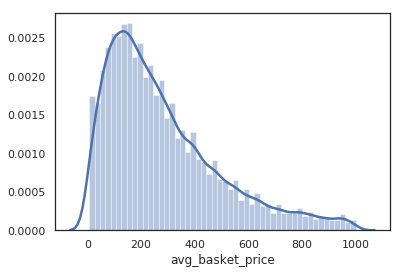

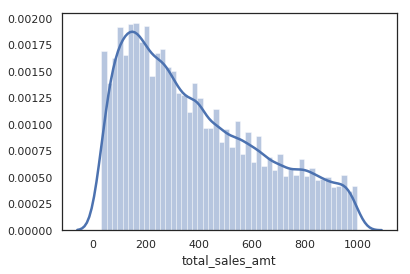

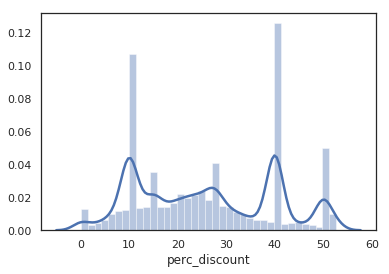

In [246]:
# Plot distribution of numerical features
for c in numCol:
    ss = df[c]
    graph_name = 'Distribution_' + c
    num_graph(graph_name, ss)

### Lets create Kmeans clustering on customer data

In [247]:
import random
random.seed( 777 )

In [248]:
df_sample = df.sample(10000)

In [249]:
# Create the matrix for kmeans algorithms
matrix = df_sample.drop(['customer_key'], axis=1).values

In [250]:
# Make sure to scale the variables
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [277.00950573 382.659982    25.76382776]


### Run PCA to get a sense of how many components would be important
On 5000 sample data seems like 5 top components can explain about 80% variance in the dataset

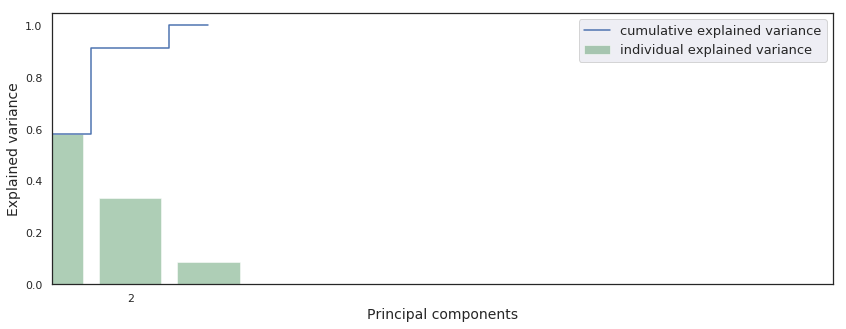

In [251]:
# Run PCA to get a sense of how many components would be important

pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)


fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);
plt.savefig(OutDir + varHandleChoice + 'pca.png')

### Lets run Kmeans clustering on the whole dataset and assess best #clusters based on silhouette score

In [218]:
# # Lets define clusters of customers based on the silhouette score
# #%%time
# max_score = 0
# best_numclus = 0
# for n_clusters in range(2,10):
#     kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
#     kmeans.fit(scaled_matrix)
#     clusters = kmeans.predict(scaled_matrix)
#     silhouette_avg = silhouette_score(scaled_matrix, clusters)
#     if(silhouette_avg > max_score):
#         max_score = silhouette_avg
#         best_numclus = n_clusters
#     print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# print("Best number of clusters", best_numclus)

In [252]:
X=scaled_matrix

For n_clusters = 2 The average silhouette_score is : 0.506405071326451
For n_clusters = 3 The average silhouette_score is : 0.4257632809672713
For n_clusters = 4 The average silhouette_score is : 0.4377363668775448
For n_clusters = 5 The average silhouette_score is : 0.39099416145418847
For n_clusters = 6 The average silhouette_score is : 0.395848065699751
For n_clusters = 7 The average silhouette_score is : 0.3863748620506627
For n_clusters = 8 The average silhouette_score is : 0.38841427038777804
For n_clusters = 9 The average silhouette_score is : 0.38994087101336183


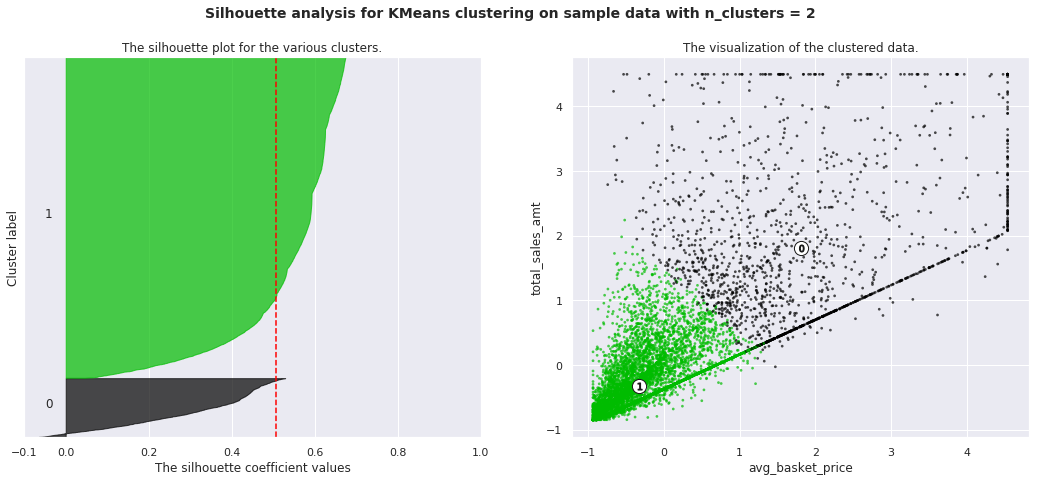

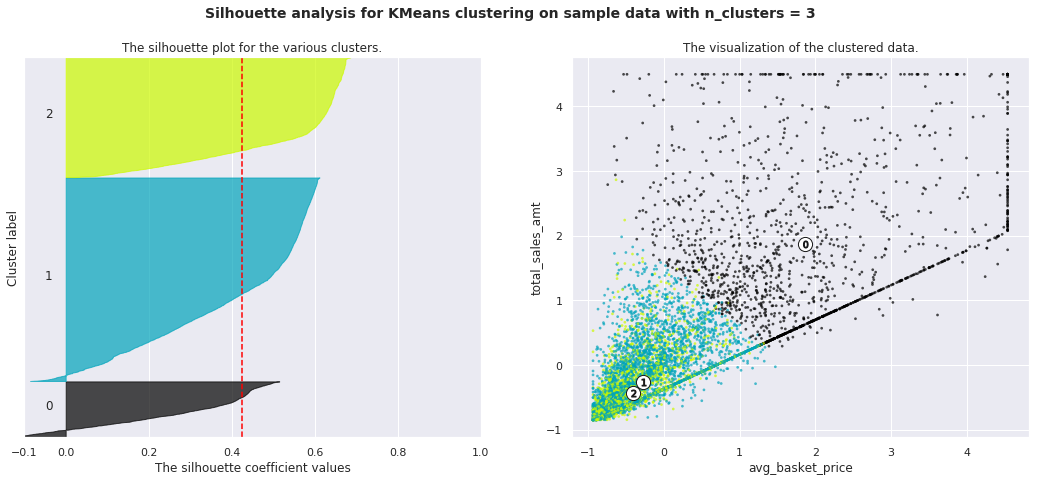

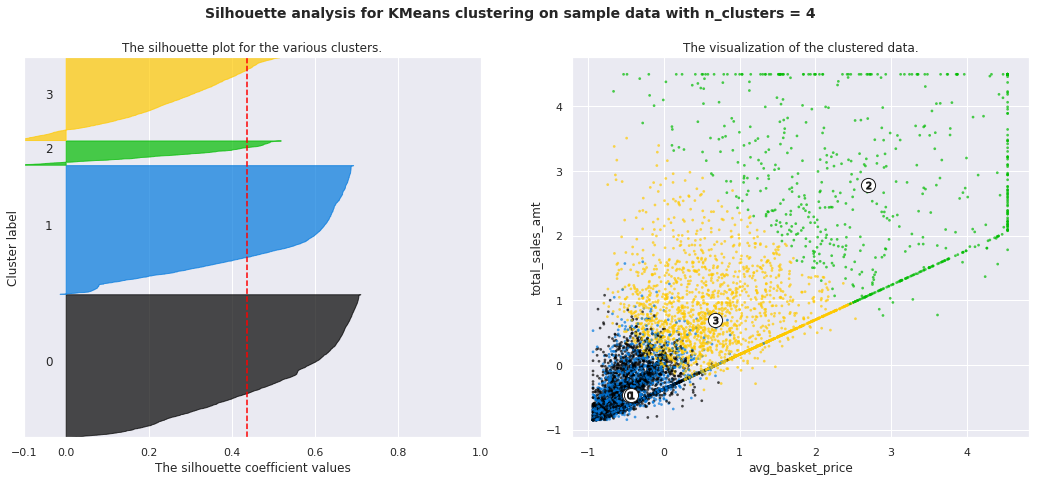

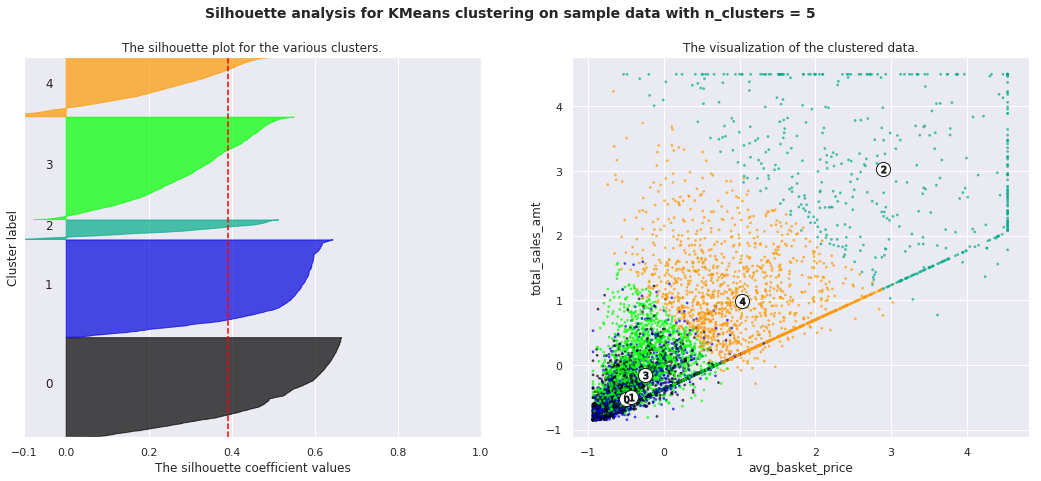

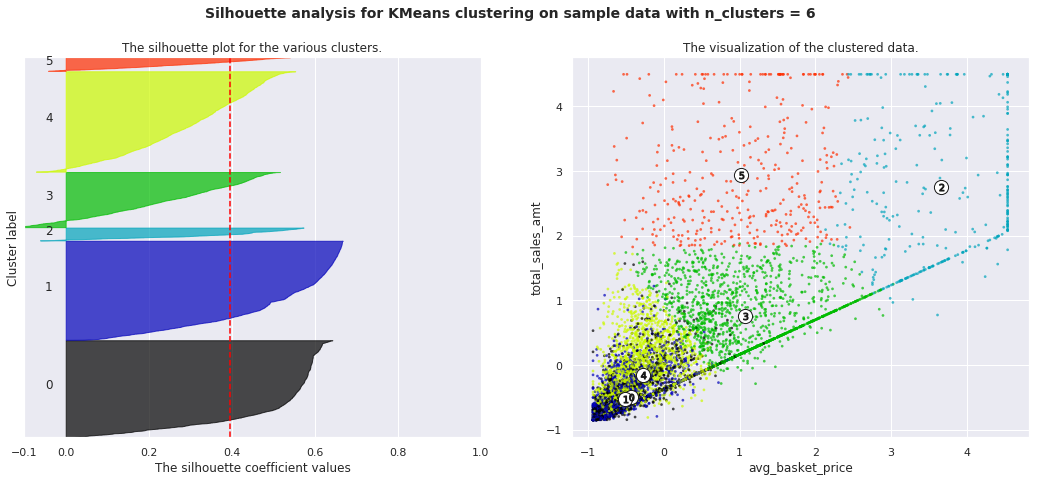

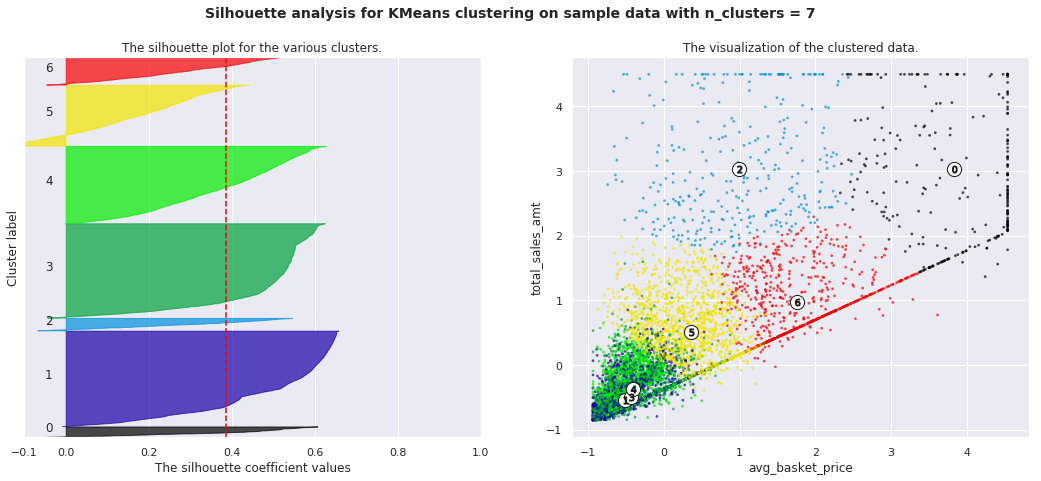

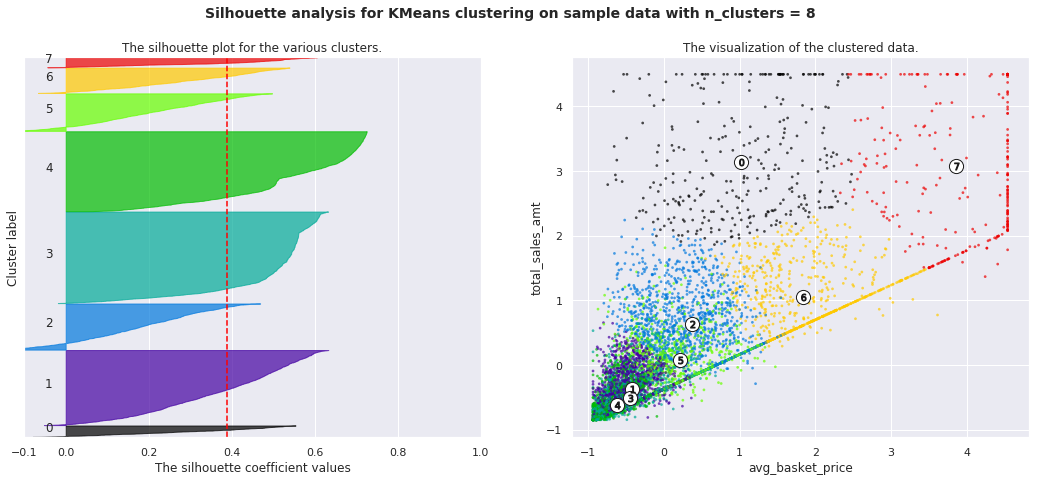

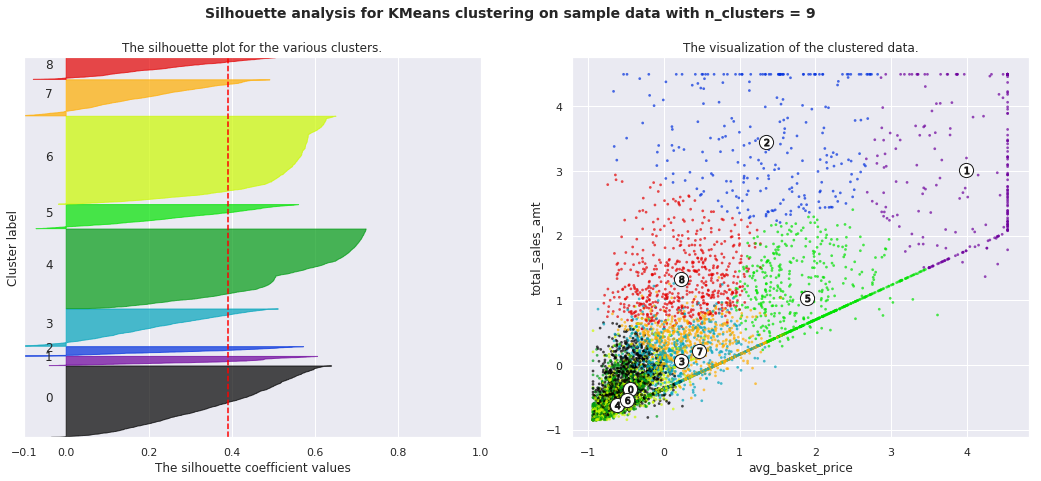

In [220]:
for n_clusters in range(2,10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    label_x = df_sample.columns[1]
    label_y = df_sample.columns[2]


    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel(label_x)
    ax2.set_ylabel(label_y)
    
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

#     plt.show()
    plt.savefig(OutDir+ varHandleChoice+ 'silhouettescore_'+str(n_clusters)+'.png')

### Seems like best number of clusters = 2 or 4 for Raw features
### Seems like best number of clusters = 2 or 4 for Capped features
### Seems like best number of clusters = 2, 3 or 4 for Filtered features


In [266]:
# Seems 2/4/3 - best number of clusters for raw features
n_clusters = 4 #best_numclus
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 4 The average silhouette_score is : 0.38995400235631283


In [267]:
# Check the number of customers in each class
pd.DataFrame(pd.Series(clusters).value_counts(), columns = ['Number of clustomers']).T

,0,3,1,2
Number of clustomers,3055,3022,2716,1207


### Lets try to visualize on PCAs

In [268]:
# Lets keep 6 top PCA components
n_components = 2
pca = PCA(n_components)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters)

/usr/local/lib/python3.4/dist-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


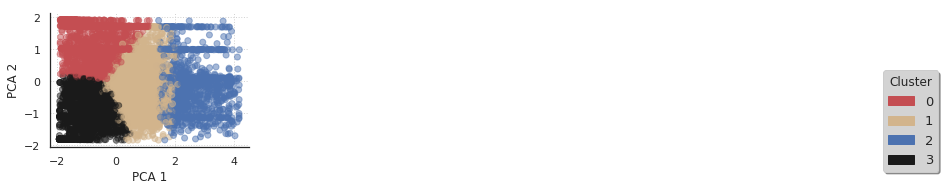

In [269]:
# in order to create a representation of the various clusters on pcas:

import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(n_components):
    for iy in range(ix+1, n_components):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()
plt.savefig(OutDir+varHandleChoice+'_'+ str(n_clusters)+'clusters_on_pcas.png')

In [270]:
df_sample['cluster_kmeans'] = pd.Series(clusters, index=df_sample.index)

In [271]:
df_sample['cluster_kmeans'].value_counts()

0    3055
3    3022
1    2716
2    1207
Name: cluster_kmeans, dtype: int64

In [272]:
# Change a few numerical columns to string
# colsToString = ['customer_key', 'cluster_kmeans']
# df_sample[colsToString] = df_sample[colsToString].astype(str)

In [273]:
df_plot = df_sample.drop('customer_key', axis=1)


/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


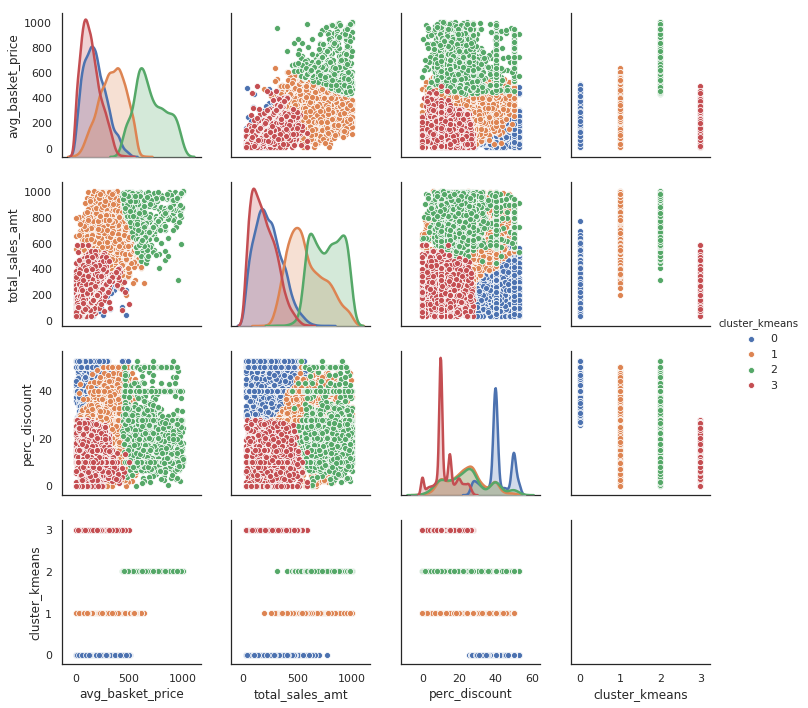

In [274]:
g = sns.pairplot(df_plot, hue = 'cluster_kmeans' )
plt.show()
g.savefig(OutDir+varHandleChoice+'_'+ str(n_clusters)+"clusters_on_vars.png")
# plt.savefig('Output/ModelFigures/clusters_on_vars.png')

### Lets try to understand each group of customers

In [275]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(df_sample[df_sample['cluster_kmeans'] == i].mean())
    test = test.T.set_index('cluster_kmeans', drop = True)
    test['size'] = df_sample[df_sample['cluster_kmeans'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('customer_key', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())
merged_df = merged_df.sort_values('size')

merged_df.head()

number of customers: 10000


,avg_basket_price,total_sales_amt,perc_discount,size
cluster_kmeans,,,,
2.0,702.008302,771.791698,24.642778,1207
1.0,343.938986,584.523807,24.070639,2716
3.0,141.566259,192.990539,12.102653,3022
0.0,183.574310,237.074687,41.225654,3055


In [276]:
merged_df.to_csv(OutDir + varHandleChoice + '_'+ str(n_clusters) + "_clusters_stats.csv")

### Lets try to visualize using Dendogram and use Hierarchical clustering to see the quality of clusters - specially if we use categorical features

In [113]:
df_sample = df_sample.drop('cluster_kmeans', axis=1)
df_sample.head()

,customer_key,total_sales_amt,perc_discount,adjusted_net_worth,gender_F,gender_M
14555,1216679,2208.00,22.880435,211307.0,1,0
13677,1145435,283.20,10.000000,418121.0,1,0
3737,237112,177.58,10.001126,852273.0,1,0
7691,558492,418.20,18.747011,393610.0,1,0
78916,6589050,232.00,27.500000,198891.0,1,0


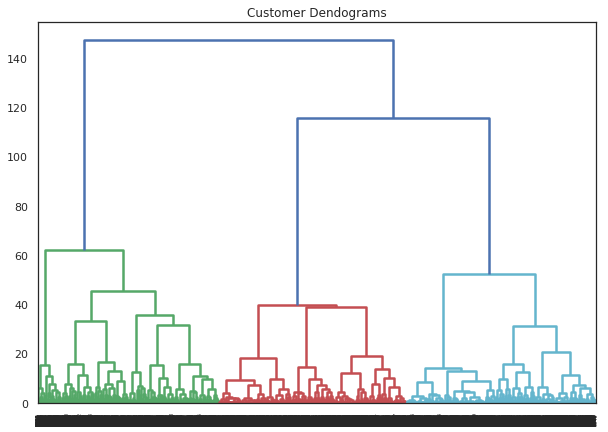

In [277]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(scaled_matrix, method='ward')) 
plt.savefig(OutDir+varHandleChoice+'_dendogram.png')

In [309]:
# Lets try Hierarchical Clustering
n_clusters = 3
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')  
clusters = cluster.fit_predict(scaled_matrix) 
print(cluster.labels_) 
silhouette_avg = silhouette_score(scaled_matrix, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

[0 2 0 ... 0 2 1]
For n_clusters = 3 The average silhouette_score is : 0.3726656888901358


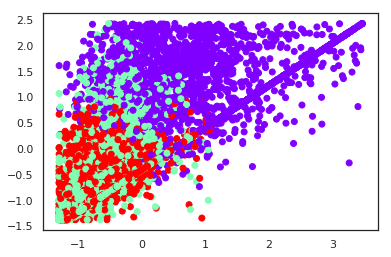

In [310]:
plt.scatter(scaled_matrix[:,0],scaled_matrix[:,1], c=cluster.labels_, cmap='rainbow')  

In [311]:
df_sample['cluster_hier'] = pd.Series(clusters, index=df_sample.index)

In [312]:
df_plot = df_sample.drop('customer_key', axis=1)


/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


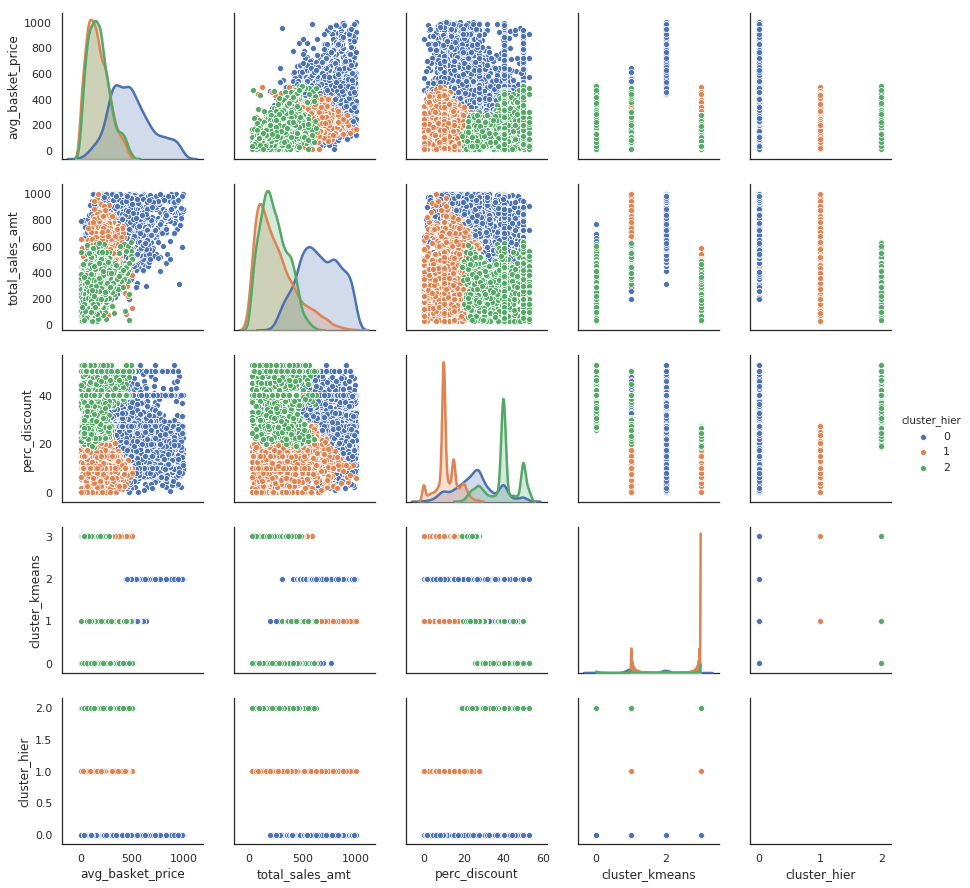

In [313]:
g = sns.pairplot(df_plot, hue = 'cluster_hier' )
# plt.show()
plt.savefig(OutDir+varHandleChoice+'_'+str(n_clusters)+ 'clusters_on_vars_hier.png')

In [314]:
# df_sample.head()

### Lets try to understand each group of customers

In [315]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(df_sample[df_sample['cluster_hier'] == i].mean())
    test = test.T.set_index('cluster_hier', drop = True)
    test['size'] = df_sample[df_sample['cluster_hier'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('customer_key', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())
merged_df = merged_df.sort_values('size')

merged_df.head()

number of customers: 10000


,avg_basket_price,total_sales_amt,perc_discount,cluster_kmeans,size
cluster_hier,,,,,
0.0,491.740222,660.269068,26.330043,1.342998,3242
2.0,179.944214,240.132464,39.595123,0.270455,3361
1.0,168.113263,258.734851,11.538731,2.629673,3397


In [316]:
merged_df = merged_df.reset_index(drop = False)

In [317]:
# merged_df[0, attributes]

In [318]:
merged_df.shape

(3, 6)

In [319]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [320]:
merged_df.columns

Index(['cluster_hier', 'avg_basket_price', 'total_sales_amt', 'perc_discount', 'cluster_kmeans', 'size'], dtype='object')

n_clusters 0
n_clusters 1
n_clusters 2


/usr/local/lib/python3.4/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.4/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.4/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.4/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is dep

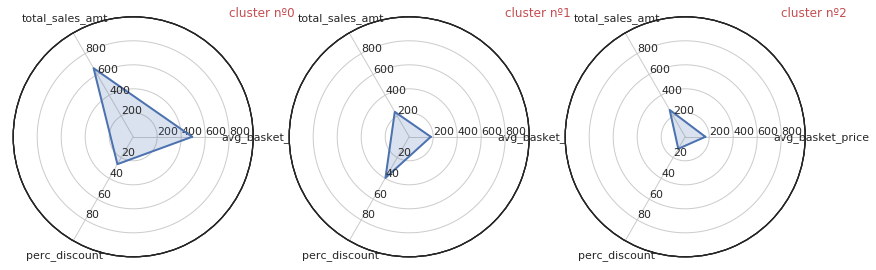

In [321]:
fig = plt.figure(figsize=(10,12))

attributes = ['avg_basket_price', 'total_sales_amt', 'perc_discount'] #['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0, 1000], [0,1000], [0, 100]]
index  = [0, 1, 2]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 

    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])
    print("n_clusters", ind)

    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    title = 'cluster nº{}'.format(i_rows)
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 
    
plt.savefig(OutDir + title + '.png')